In [1]:
import sys
sys.path.append("../")
sys.path.append("../..")

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(14, 4)

# 1.Data ingestion parameter
import pandas as pd
from datetime import timedelta
duration_day = 1 # 1 or 7
start_time = pd.to_datetime("2020-05-14 00:00:00")
end_time = start_time + timedelta(days = duration_day)
duration = {'start_time':start_time, 'end_time':end_time}
db_name = 'air_indoor_도서관'
feature_list = ['in_co2']# ['in_noise','in_pm01', 'in_pm01_raw', 'in_pm10', 'in_pm10_raw', 'in_pm25','in_pm25_raw', 'in_temp', 'voc']
feature_name = feature_list[0]


fig_width_num = 4
fig_width = 30
fig_height = 30


# 2.Data manipulation parameter
freq_min = 60
import datetime
timedelta_frequency_min = datetime.timedelta(minutes= freq_min)
# 3. Nan Processing Parameter
# 3-1. NanLImitProcessingInfo = {'type':'ratio', 'ConsecutiveNanLimit':0.05, 'totalNaNLimit':1} # seconds
# 3-2. NanLImitProcessingInfo = {'type':'time', 'ConsecutiveNanLimit':1*60*60, 'totalNaNLimit':5*60*60} #seconds
# 3-3.
NanInfoForClenData = {'type':'num', 'ConsecutiveNanLimit':100, 'totalNaNLimit':100}

In [2]:
from Clust.clust.ingestion.influx import influx_Client_v2 as influx_Client, bucket_data
from Clust.setting import influx_setting_KETI as ins
db_client = influx_Client.influxClient(ins.CLUSTDataServer2)
dataSet = bucket_data.get_all_msData_in_oneBucket(start_time, end_time, db_client, db_name)

/home/jwmoon/.local/lib/python3.8/site-packages/influxdb_client/client/warnings.py:31: MissingPivotFunction: The query doesn't contains the pivot() function.

The result will not be shaped to optimal processing by pandas.DataFrame. Use the pivot() function by:

    import "influxdata/influxdb/schema" schema.measurements(bucket: "air_indoor_도서관") |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")

You can disable this warning by:
    import warnings
    from influxdb_client.client.warnings import MissingPivotFunction

    warnings.simplefilter("ignore", MissingPivotFunction)

For more info see:
    - https://docs.influxdata.com/resources/videos/pivots-in-flux/
    - https://docs.influxdata.com/flux/latest/stdlib/universe/pivot/
    - https://docs.influxdata.com/flux/latest/stdlib/influxdata/influxdb/schema/fieldsascols/

  warnings.warn(message, MissingPivotFunction)


In [3]:
from Clust.clust.meta.metaDataManager import bucketMeta
from Clust.clust.ingestion.mongo import mongoClient
#db에서 가져온 데이터로 만든 민맥스
mongo_client = mongoClient.mongoClient(ins.CLUSTMetaInfo2)
min_max = bucketMeta.get_min_max_info_from_bucketMeta(mongo_client, db_name)

5 ---> 5


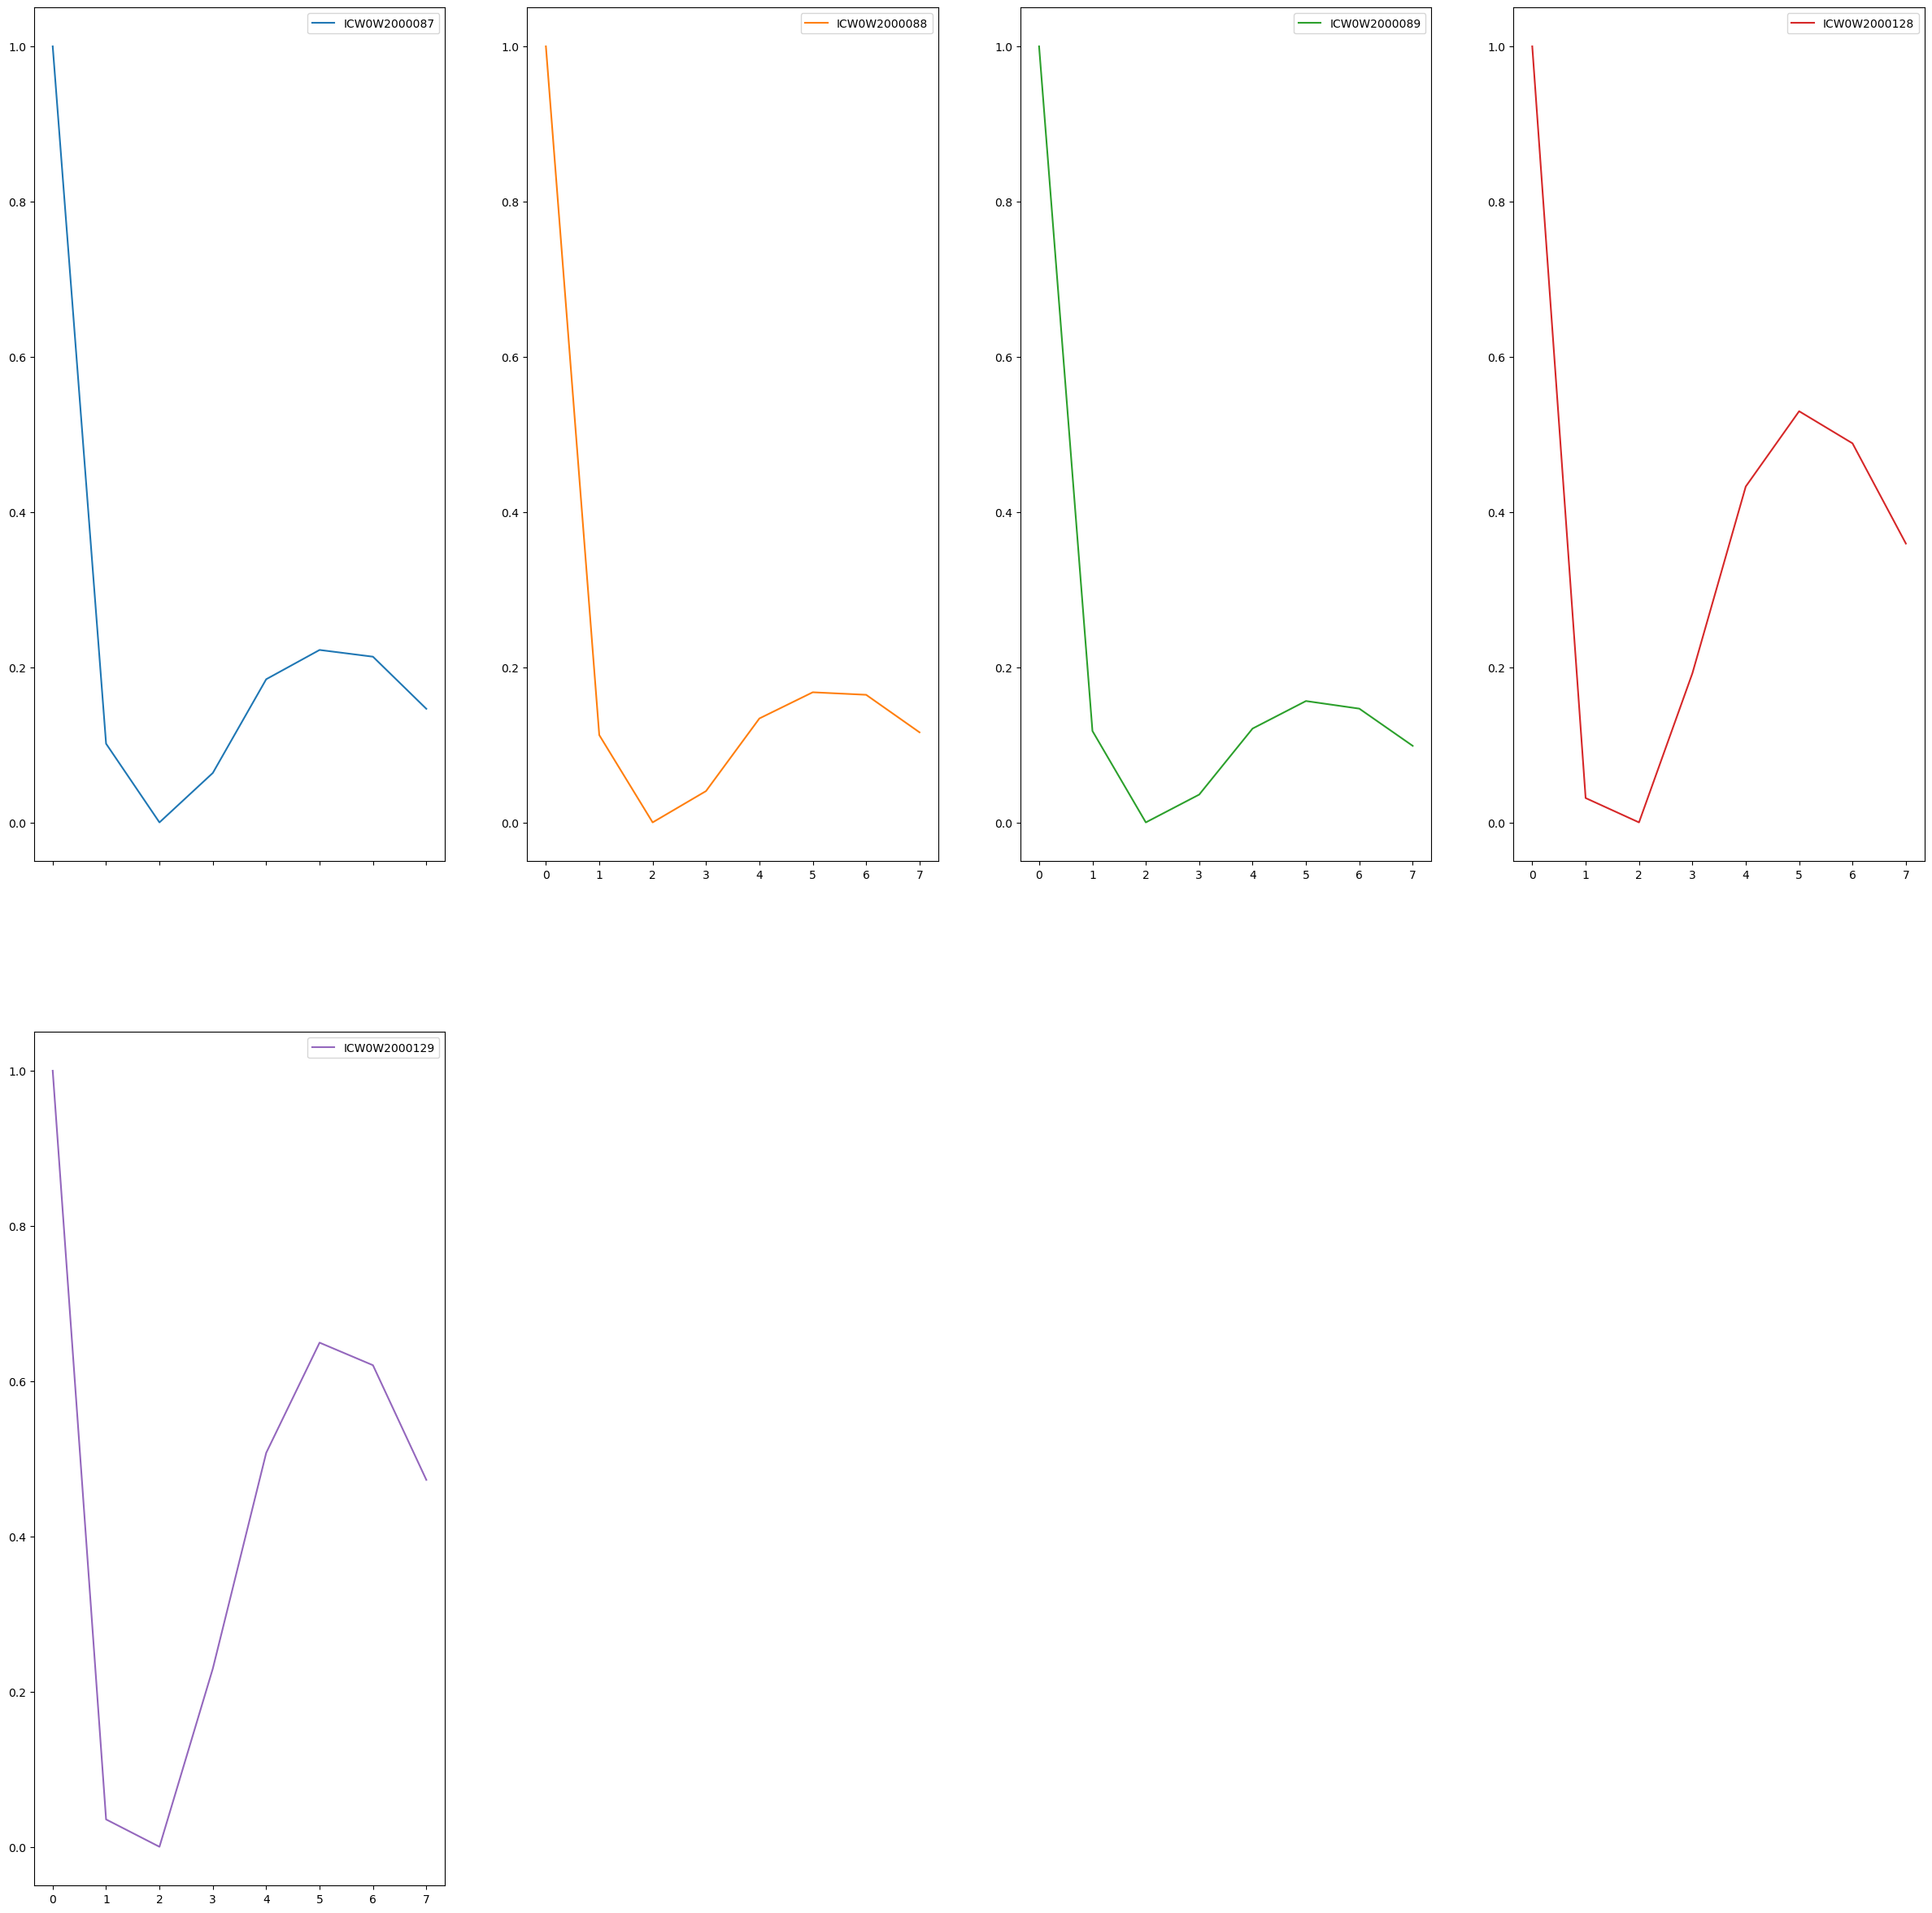

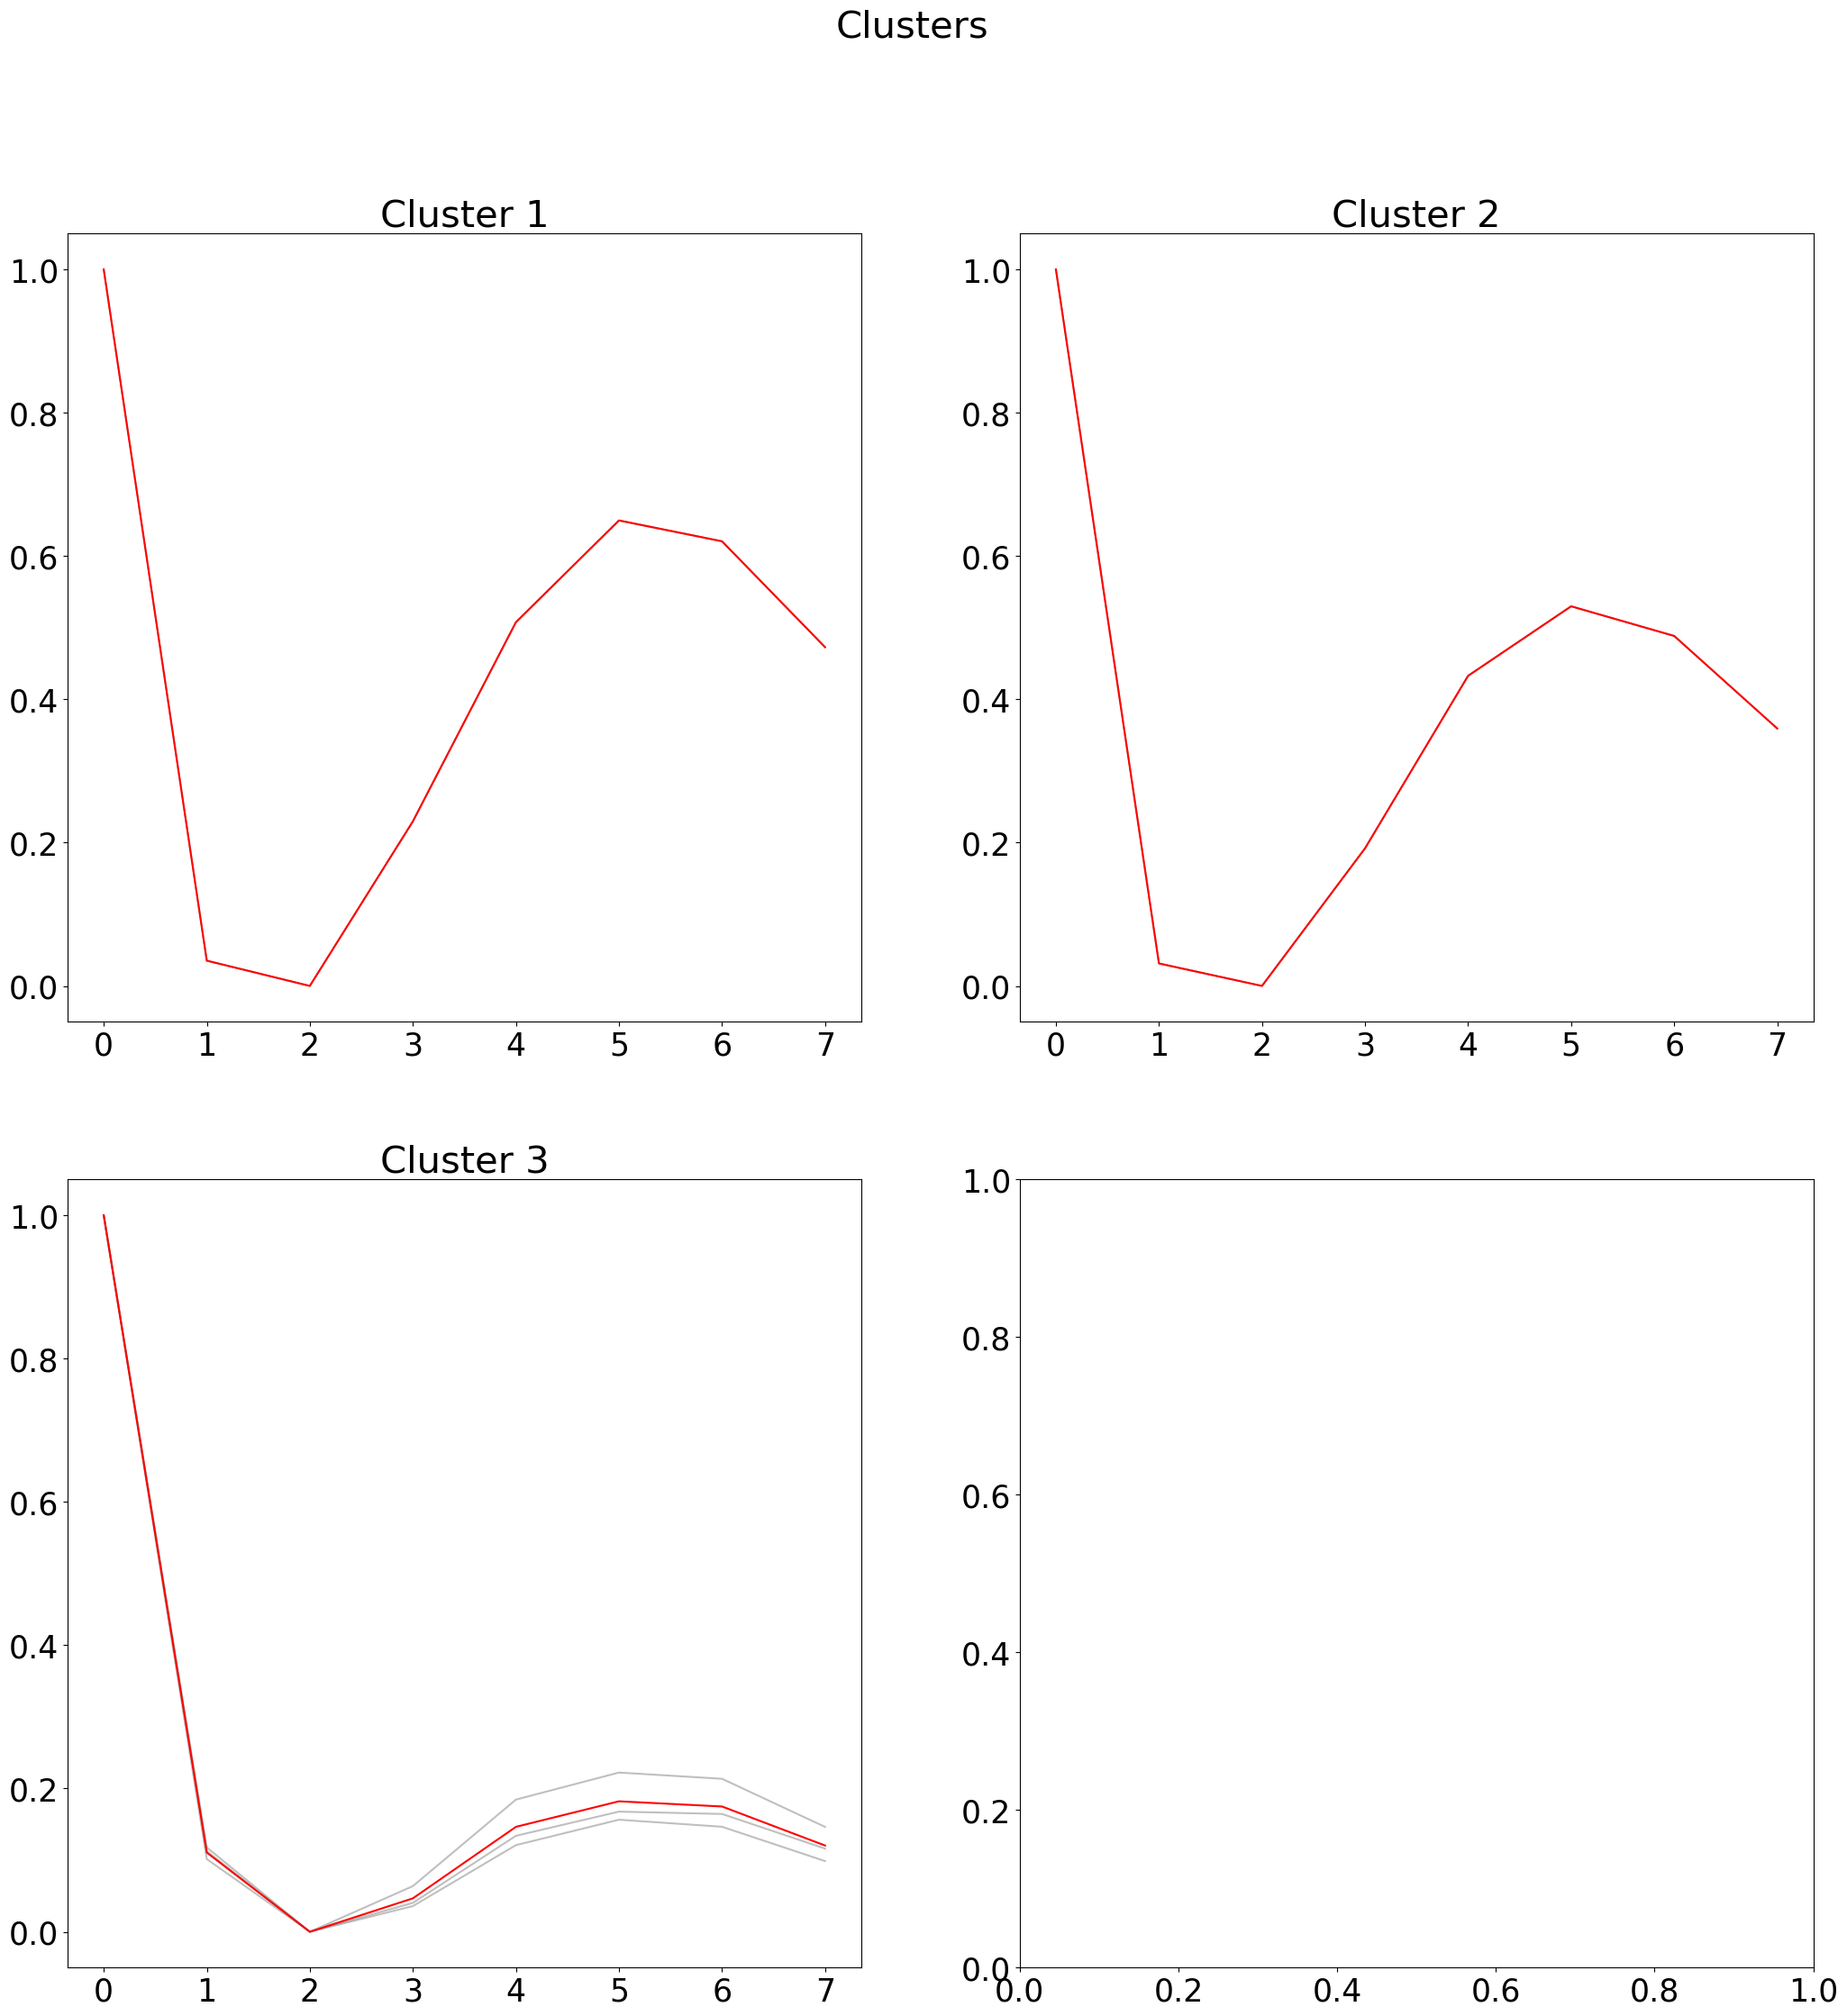

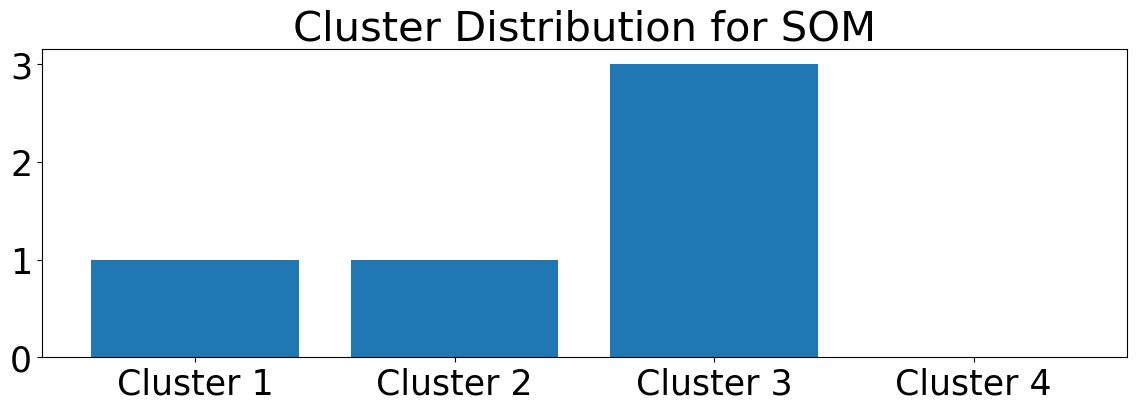

In [4]:
from Clust.clust.ML.clustering import custom 
result, figdata = custom.get_somClustering_result_from_dataSet(dataSet,feature_name, 
        min_max, timedelta_frequency_min, None, NanInfoForClenData,  fig_width, fig_height)